In [ ]:
# 📦 导入依赖
import ROOT
import uproot
import math
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import pandas as pd
import os
import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

In [ ]:
# 打开 ROOT 文件，载入 events tree
Threshold=0.5*0.1328
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
ECAL_layers=30
def ReadData_Energy(DataPath,ParticleEnergy,precision=0.01):
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for i_E in range(len(ParticleEnergy)):
    #for i_E in range(0,1):
        input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
        E_layers,N_layers,E_truth = ReadRoot(input_file_name)
        E_layers_all = np.vstack((E_layers_all, np.vstack(E_layers)))
        N_layers_all = np.vstack((N_layers_all, np.vstack(N_layers)))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
        E_truth_all = np.round(E_truth_all/precision)*precision
    return E_layers_all, N_layers_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for input_file in root_files:
        E_layers, N_layers, E_truth = ReadRoot(input_file)
        E_layers_all = np.vstack((E_layers_all, E_layers))
        N_layers_all = np.vstack((N_layers_all, N_layers))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, E_truth_all
def ReadRoot(input_file_name):
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    E_truth = tree["MCParticles.p0"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    calo_layer = cellID & 0x7F
    num_events = len(energy)
    E_layers = []
    N_layers = []
    for i_event in range(num_events):
        # convert to numpy arrays
        layers = calo_layer[i_event].to_numpy()
        energies = energy[i_event].to_numpy()
        E_layers_event = np.bincount(layers, weights=energies, minlength=ECAL_layers)
        N_layers_event = np.bincount(layers, minlength=ECAL_layers)
        E_layers.append(E_layers_event)
        N_layers.append(N_layers_event)
    E_truth_flat = ak.to_numpy(ak.flatten(E_truth, axis=None))
    return E_layers,N_layers,E_truth_flat
#Read Data
DataPath_Validate="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Train="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Uniform="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Uniform"
Energy_Train=(0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,15.0,25.0,35.0,45.0,55.0,65.0)
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)#add 0.1 0.25 after all data is ready
#E_layers_train, N_layers_train, E_truth_train = ReadData_Energy(DataPath_Train,Energy_Train)
E_layers_test, N_layers_test, E_truth_test = ReadData_Energy(DataPath_Validate,Energy_test)
E_layers_uniform, N_layers_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

In [ ]:
#zero suppression
def zero_suppression(E_layers, N_layers,E_truth):
    N_sum = np.array([np.sum(n) for n in N_layers])
    E_sum = np.array([np.sum(e) for e in E_layers])
    E_truth = np.array(E_truth)

    mask = N_sum > 0
    E_layers_filtered = [E_layers[i] for i in range(len(E_layers)) if mask[i]]
    N_layers_filtered = [N_layers[i] for i in range(len(N_layers)) if mask[i]]    
    E_truth_filtered = E_truth[mask]
    E_sum_filtered = E_sum[mask]
    N_sum_filtered = N_sum[mask]

    print("length after zero suppression:", len(E_layers_filtered), len(N_layers_filtered), len(E_sum_filtered), len(N_sum_filtered), len(E_truth_filtered))
    return E_layers_filtered, N_layers_filtered, E_sum_filtered, N_sum_filtered, E_truth_filtered

#Start from shower layer
def start_from_shower_layer(arr):
    N = len(arr)
    nonzero_idx = np.argmax(arr != 0)
    trimmed = arr[nonzero_idx:]
    if len(trimmed) < N:
        trimmed = np.pad(trimmed, (0, N - len(trimmed)), 'constant')
    return trimmed

def Event_Selection(E_layers,N_layers,E_truth):
    E_layers, N_layers, E_sum, N_sum, E_truth = zero_suppression(E_layers, N_layers, E_truth)
    E_layers = np.array([start_from_shower_layer(ev) for ev in E_layers])
    N_layers = np.array([start_from_shower_layer(ev) for ev in N_layers])
    return E_layers, N_layers, E_sum, N_sum, E_truth

#E_layers_train, N_layers_train, E_sum_train, N_sum_train, E_truth_train = Event_Selection(E_layers_train, N_layers_train, E_truth_train)
E_layers_uniform, N_layers_uniform, E_sum_uniform, N_sum_uniform, E_truth_uniform = Event_Selection(E_layers_uniform, N_layers_uniform, E_truth_uniform)
E_layers_test, N_layers_test, E_sum_test, N_sum_test, E_truth_test = Event_Selection(E_layers_test, N_layers_test, E_truth_test)
#Draw E_truth
plt.figure(figsize=fig_size)
plt.hist(E_truth_uniform, bins=1000, range=(0, 100), edgecolor="black")
#plt.hist(E_truth_test, bins=20, range=(0, 1), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.ylabel("Counts")
plt.yscale("log")
plt.title("Distribution of E_truth_test")
plt.grid(True)
plt.show()

In [ ]:
def plot_binned(x, y, num_bins=30, color="blue", label=None):
    """Plot mean y in bins of x."""
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

fit_range = (0, 65)
mask_fit = (E_truth_uniform > fit_range[0]) & (E_truth_uniform < fit_range[1])
# E_sum: linear
coeffs_calibE = np.polyfit(E_sum_uniform[mask_fit], E_truth_uniform[mask_fit], 1)
coeffs_calibE_inv = np.polyfit(E_truth_uniform[mask_fit], E_sum_uniform[mask_fit], 1)
E_fit_line = np.poly1d(coeffs_calibE_inv)
# N_sum: exponential
coeffs_calibN, _ = curve_fit(exp_func, N_sum_uniform[mask_fit], E_truth_uniform[mask_fit], p0=(1,0.01,1))
E_fit = exp_func(N_sum_uniform, *coeffs_calibN)
interp_inv = interp1d(E_fit, N_sum_uniform, bounds_error=False, fill_value="extrapolate")

plt.figure(figsize=fig_size)
plot_binned(E_truth_uniform, E_sum_uniform, color="blue", label="Binned mean")
X_line=np.linspace(fit_range[0], fit_range[1], 200)
plt.plot(X_line, E_fit_line(X_line), color="red", linestyle="--", label="Fit Line")
plt.ylabel("E_sum_uniform")
plt.xlabel("E_truth_uniform")
plt.title("Uniform samples")
plt.grid(True, linestyle="-", alpha=0.5)
plt.legend(loc="upper left")

plt.figure(figsize=fig_size)
plot_binned(E_truth_uniform, N_sum_uniform, color="orange", label="Binned mean")
E_vals = np.linspace(fit_range[0], fit_range[1], 200)
N_vals = interp_inv(E_vals)
plt.plot(E_vals, N_vals, color="red", linestyle="--", label="Fit Line")
plt.ylabel("N_sum_uniform")
plt.xlabel("E_truth_uniform")
plt.title("Uniform samples")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")

E_calib = np.poly1d(coeffs_calibE)
E_sum_uniform_calib = E_calib(E_sum_uniform)
#E_sum_train_calib   = E_calib(E_sum_train)
E_sum_test_calib    = E_calib(E_sum_test)
N_sum_uniform_calib = exp_func(N_sum_uniform, *coeffs_calibN)
#N_sum_train_calib   = exp_func(N_sum_train, *coeffs_calibN)
N_sum_test_calib    = exp_func(N_sum_test, *coeffs_calibN)

plt.figure(figsize=fig_size)
plot_binned(E_sum_uniform_calib,E_truth_uniform, color="blue", label="Binned mean")
plt.xlabel("E_sum_uniform_calib")
plt.ylabel("E_truth_uniform")
plt.title("Calibration (E_sum)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")

plt.figure(figsize=fig_size)
plot_binned(N_sum_uniform_calib, E_truth_uniform, color="orange", label="Binned mean")
plt.xlabel("N_sum_uniform_calib")
plt.ylabel("E_truth_uniform")
plt.title("Calibration (N_sum)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")
plt.show()

In [28]:
class WeightedRelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8, power=1):
        super().__init__()
        self.eps = eps
        self.power = power  # 控制权重下降速度

    def forward(self, y_pred, y_true):
        weight = 1.0 / (y_true + self.eps) ** self.power
        return torch.mean(weight * ((y_true - y_pred) / (y_true + self.eps)) ** 2)
class RelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        return torch.mean(rel**2)
class RelativeMSELoss_Power3(nn.Module):
    def __init__(self, eps=1e-8, power=3):
        super().__init__()
        self.eps = eps
        self.power = power
    def forward(self, y_pred, y_true):
        out = ((y_pred - y_true)**2) / ((y_true + self.eps)**self.power)
        return torch.mean(out)   
class HuberRelativeLoss(nn.Module):
    def __init__(self, delta=0.1, eps=1e-8):
        super().__init__()
        self.delta = delta
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        denom = torch.clamp(y_true + self.eps, min=1e-6)
        ratio = y_pred / denom
        ratio = torch.clamp(ratio, min=-0.99)  # 保证 log1p 有效
        log = torch.log1p(ratio)
        abs_log = torch.abs(log)
        abs_rel = torch.abs(rel)
        #Basic
        loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        #Test
        #loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, 0.5 * abs_log)
        #loss = abs_rel*abs_rel + (1-abs_rel)*(rel**2)
        return torch.mean(loss)
class ResidualLinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, activation=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation if activation is not None else nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.linear(x)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out

class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        print(f"Hidden dims: {hidden_dims}, Dropout: {dropout}, Activation: {activation}")
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(ResidualLinearBlock(prev_dim, h, dropout=dropout, activation=activation))
            prev_dim = h
        self.model = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)

    def forward(self, x):
        x = self.model(x)
        return self.output_layer(x).squeeze(-1)

# ==== Training function ====
def train_mlp(X_train,y_train,X_validate,y_validate,
            activation=nn.Sigmoid(),
            loss=HuberRelativeLoss(),
              hidden_dims=[128, 64, 32], 
              dropout=0.1, 
              lr=1e-3, 
              batch_size=4096, 
              epochs=500,
              patience=10,
              val_split=0.2,
              random_state=42):
    
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    print(f"Random state: {random_state}")
    print(f"Training samples: {len(X_train)}, Validation samples: {int(len(X_validate))}")
    print(f"learning rate: {lr}, batch size: {batch_size}, epochs: {epochs}, patience: {patience}")
    print(f"Loss function: {loss}")

    # Convert numpy arrays to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_validate   = torch.tensor(X_validate, dtype=torch.float32)
    y_validate   = torch.tensor(y_validate, dtype=torch.float32)
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset   = TensorDataset(X_validate, y_validate)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model
    model = MLPRegressor(input_dim=X_train.shape[1], hidden_dims=hidden_dims, dropout=dropout,
                         activation=activation).to(device)

    # Optimizer & Loss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-5)
    criterion = loss

    warmup_epochs = 5
    base_lr = lr
    min_lr = 1e-5

    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return float(current_epoch + 1) / warmup_epochs
        else:
            progress = (current_epoch - warmup_epochs) / (epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))  # 范围 0~1
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    # === Training loop with best model tracking ===
    best_val_loss = float("inf")
    best_state_dict = None
    train_loss_history, val_loss_history, beta_history = [],  [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        scheduler.step()
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                val_loss += loss.item() * xb.size(0)

        train_loss /= len(train_dataset)
        val_loss   /= len(val_dataset)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}| LR: {scheduler.get_last_lr()[0]:.6f}")

        # Nan stopping
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("NaN encountered. Stopping training.")
            break
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    # Restore best model
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    
    plt.figure(figsize=fig_size)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    return model

In [29]:
E_layers_uniform_ratio = E_layers_uniform / (E_sum_uniform[:, np.newaxis])
N_layers_uniform_ratio = N_layers_uniform / (N_sum_uniform[:, np.newaxis])
E_layers_test_ratio    = E_layers_test / (E_sum_test[:, np.newaxis])
N_layers_test_ratio    = N_layers_test / (N_sum_test[:, np.newaxis])
E_layers_uniform_exp = np.exp(E_layers_uniform_ratio)
N_layers_uniform_exp = np.exp(N_layers_uniform_ratio)
E_layers_test_exp    = np.exp(E_layers_test_ratio)
N_layers_test_exp    = np.exp(N_layers_test_ratio)

E_N_layers_uniform =  E_layers_uniform/(N_layers_uniform+1e-6)
E_N_layers_test    =  E_layers_test/(N_layers_test+1e-6)
EN_layers_uniform = E_N_layers_uniform * N_layers_uniform
EN_layers_test    = E_N_layers_test * N_layers_test

In [30]:

X_train = np.hstack([
    E_layers_uniform, 
    E_layers_uniform_ratio,
    E_sum_uniform_calib[:, np.newaxis],
    N_layers_uniform, 
    N_layers_uniform_ratio,
    N_sum_uniform_calib[:, np.newaxis],
    E_N_layers_uniform,
])
X_test = np.hstack(
    [E_layers_test, 
        E_layers_test_ratio,
     E_sum_test_calib[:,np.newaxis], 
     N_layers_test, 
        N_layers_test_ratio,
     N_sum_test_calib[:,np.newaxis],
     E_N_layers_test,
])
y_train = E_truth_uniform
y_test = E_truth_test

#Scaling
random_state = 42
val_split = 0.2
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=val_split, random_state=random_state)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)

def plot_features_in_batches(X, feature_names=None, bins=50, n_cols=2, figsize=(12, 6)):
    n_features = X.shape[1]
    n_rows = (n_cols + n_cols - 1) // n_cols  # 每页只有 1 行 2 列的话 n_rows=1
    for start in range(0, n_features, n_cols):
        end = min(start + n_cols, n_features)
        plt.figure(figsize=figsize)
        for i, j in enumerate(range(start, end)):
            plt.subplot(1, n_cols, i + 1)
            plt.hist(X[:, j], bins=bins, color='skyblue', edgecolor='black')
            plt.yscale('log')
            if feature_names:
                plt.title(feature_names[j], fontsize=10)
            else:
                plt.title(f"Feature {j}", fontsize=10)
        plt.subplots_adjust(hspace=0.4, wspace=0.3)
        plt.show()
#plot_features_in_batches(X_train, bins=50, n_cols=2, figsize=(12, 6))

Using device: cuda
Random state: 42
Training samples: 999762, Validation samples: 249941
learning rate: 0.001, batch size: 4096, epochs: 50, patience: 10
Loss function: HuberRelativeLoss()
Hidden dims: [64, 32, 16], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Epoch 001/50 | Train Loss: 0.087463 | Val Loss: 0.079152| LR: 0.000400
Epoch 002/50 | Train Loss: 0.049615 | Val Loss: 0.012530| LR: 0.000600
Epoch 003/50 | Train Loss: 0.013140 | Val Loss: 0.004630| LR: 0.000800
Epoch 004/50 | Train Loss: 0.009932 | Val Loss: 0.003612| LR: 0.001000
Epoch 005/50 | Train Loss: 0.008501 | Val Loss: 0.004272| LR: 0.001000
Epoch 006/50 | Train Loss: 0.006695 | Val Loss: 0.002394| LR: 0.000999
Epoch 007/50 | Train Loss: 0.006285 | Val Loss: 0.002344| LR: 0.000995
Epoch 008/50 | Train Loss: 0.005201 | Val Loss: 0.001842| LR: 0.000989
Epoch 009/50 | Train Loss: 0.005261 | Val Loss: 0.001819| LR: 0.000981
Epoch 010/50 | Train Loss: 0.003785 | Val Loss: 0.004239| LR: 0.000970
Epoch 011/50 | Train Los

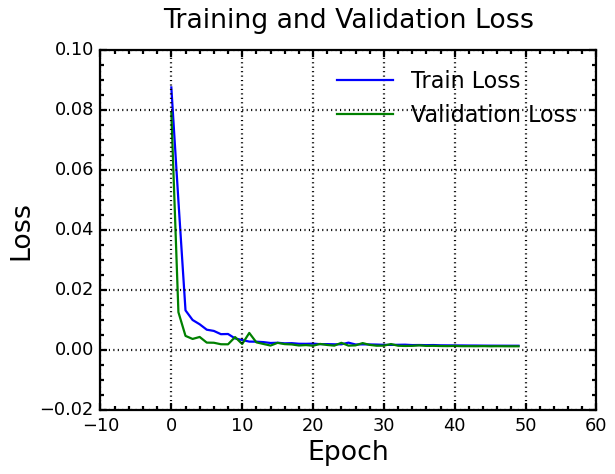

In [69]:
ParameterScan=[1e-3,]#not used, but the loop is kept for future parameter scanning
Reco_hist_mlp_all = []
for lr in ParameterScan:
  mlp_model= train_mlp(X_train_scaled, y_train,X_validate_scaled, y_validate,
                    activation=nn.PReLU(),
                    hidden_dims=[64,32,16],
                      dropout=0.1,
                      loss=HuberRelativeLoss(delta=0.1),
                      lr=lr,
                      batch_size=4096,
                      epochs=50,
                      patience=10,
                      random_state=random_state)
  device = next(mlp_model.parameters()).device
  torch.save(mlp_model, DataPath_Validate+f"/Models/MLP.pth")


Step 1 Linear fit coeffs: [ 9.30892594e-05 -7.25386267e-03]


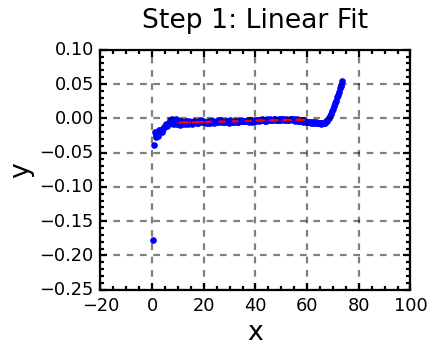

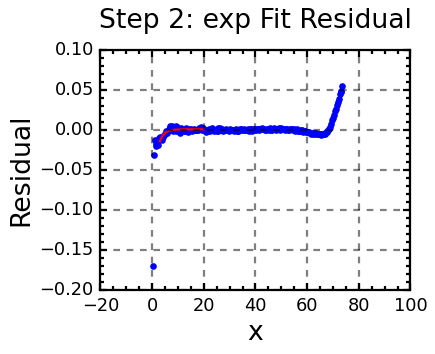

Step 3 Linear fit coeffs: [ 6.12438791e-05 -6.88768496e-03]


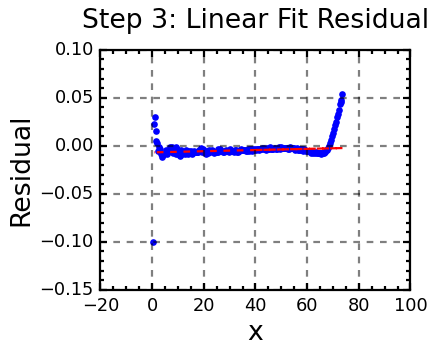

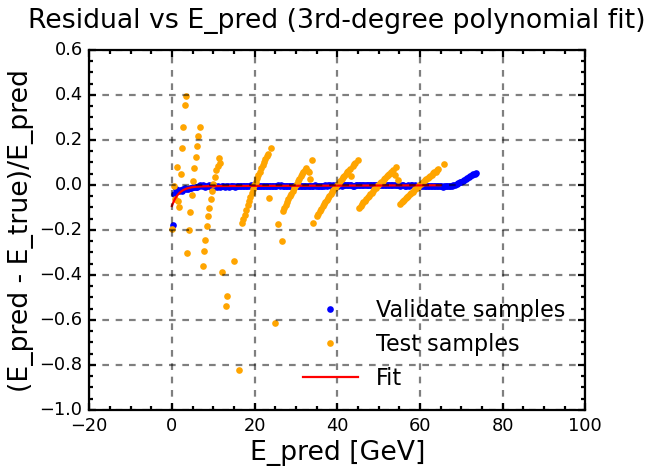

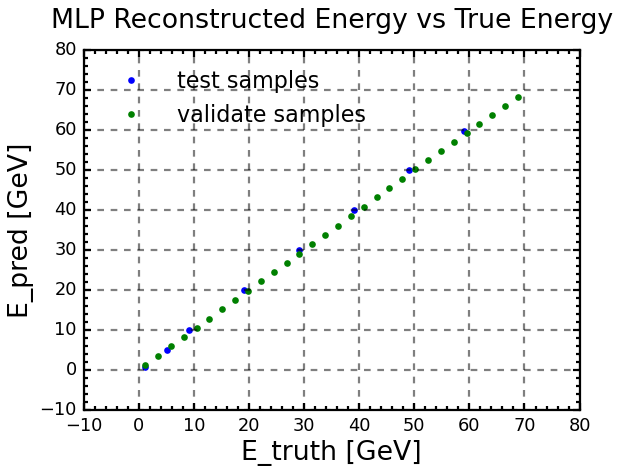

In [70]:
def Combined_fit(x, y, fit_range=(0,65), plot=True, num_bins=100):
    #Step 1: Linear
    linear_range = (10,60)
    mask_lin = (x > linear_range[0]) & (x < linear_range[1])
    coeffs_lin = np.polyfit(x[mask_lin], y[mask_lin], 1)
    y_lin = np.poly1d(coeffs_lin)(x)
    residual = y - y_lin
    print("Step 1 Linear fit coeffs:", coeffs_lin)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, y, num_bins=num_bins, color="blue", label="Data (bin mean)")
        plt.plot(x[mask_lin], y_lin[mask_lin], color="red", linestyle="--", label="Step1: Linear")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Step 1: Linear Fit")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Step 2: exp fit
    #residual = y
    fit_range = (3, 20)
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    def fit_func2(x, a, b, c):
        return a * np.exp(b * x) + c
    coeff_fit2, _ = curve_fit(fit_func2, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    x_fit2 = np.linspace(fit_range[0], fit_range[1], 200)
    y_fit2 = fit_func2(x_fit2, *coeff_fit2)
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
        plt.plot(x_fit2, y_fit2, color="red", linestyle="-", label="Step2: exp Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 2: exp Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    residual = y - fit_func2(x, *coeff_fit2)

    # Step 3: exp fit
    # if plot:
    #     plt.figure(figsize=(5,4))
    #     plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
    #     plt.xlabel("x")
    #     plt.ylabel("Residual")
    #     plt.title("Step 3: exp Fit Residual")
    #     plt.grid(True, linestyle="--", alpha=0.5)
    #     plt.show()
    # fit_range = (10, 30)
    # mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    # def fit_func3(x, a, b, c):
    #     return a * np.exp(b * x) + c
    # coeff_fit3, _ = curve_fit(fit_func3, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    # x_fit3 = np.linspace(fit_range[0], fit_range[1], 200)
    # y_fit3 = fit_func3(x_fit3, *coeff_fit3)
    # if plot:
    #     plt.plot(x_fit3, y_fit3, color="red", linestyle="-", label="Step3: exp Fit")

    # residual = y - fit_func2(x, *coeff_fit2) - fit_func3(x, *coeff_fit3)

    # Step 4: Linear again
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    params_lin2 = np.polyfit(x[mask_fit], residual[mask_fit], 1)
    y_lin2 = np.poly1d(params_lin2)(x)
    print("Step 3 Linear fit coeffs:", params_lin2)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual after Step2 (bin mean)")
        plt.plot(x, y_lin2, color="red", linestyle="--", label="Step3: Linear Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 3: Linear Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Final combined function
    def f(x_val):
        return ( 
                fit_func2(x_val, *coeff_fit2) + 
                #fit_func3(x_val, *coeff_fit3) + 
                np.poly1d(params_lin2)(x_val))
    return f
def build_reco_hist(y_pred, y_truth, Energy_test, Nbins=50):
    reco_hist = []
    for i_E, E_truth in enumerate(Energy_test):
        mask = (y_truth == E_truth)
        reco_energy = y_pred[mask]

        if len(reco_energy) == 0:
            print(f"No events found for E_truth = {E_truth} GeV, skipping.")
            continue

        mean = np.mean(reco_energy)
        rms = np.std(reco_energy)
        valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)

        filtered_data = reco_energy[valid_mask]
        counts, bin_edges = np.histogram(filtered_data, bins=Nbins)

        reco_hist.append({
            "E_truth": E_truth,
            "counts": counts,
            "bin_edges": bin_edges
        })
    return reco_hist

X_validate_tensor = torch.tensor(X_validate_scaled, dtype=torch.float32).to(device)
y_pred = mlp_model(X_validate_tensor).detach().cpu().numpy()
y_true = y_validate
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred_test_mlp = mlp_model(X_test_tensor).detach().cpu().numpy()
# Reco_hist_mlp_all.clear()
# Reco_hist_mlp = build_reco_hist(y_pred_test_mlp, E_truth_test, Energy_test, Nbins=50)
# Reco_hist_mlp_all.append(Reco_hist_mlp)

fit_range = (0, 65) 
mask = y_pred>0
residual_E = (y_pred[mask] - y_true[mask]) / y_pred[mask]
E_calib_fit = Combined_fit(y_pred[mask], residual_E, fit_range=fit_range, plot=True, num_bins=200)
x_fit = np.linspace(fit_range[0], fit_range[1], 200)
y_fit = E_calib_fit(x_fit)
plt.figure(figsize=fig_size)
plot_binned(y_pred[mask], residual_E, num_bins=200, color="blue", label="Validate samples")
plot_binned(y_pred_test_mlp, (y_pred_test_mlp - y_test) / y_pred_test_mlp,num_bins=200, color="orange", label="Test samples")
plt.plot(x_fit, y_fit, color='red', label='Fit')
plt.xlabel("E_pred [GeV]")
plt.ylabel("(E_pred - E_true)/E_pred")
plt.title("Residual vs E_pred (3rd-degree polynomial fit)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="lower right")
plt.show()

y_pred_calib = y_pred*(1-E_calib_fit(y_pred))
y_pred_test_mlp_calib = y_pred_test_mlp*(1-E_calib_fit(y_pred_test_mlp))
Reco_hist_mlp_all.clear()
Reco_hist_mlp = build_reco_hist(y_pred_test_mlp_calib, E_truth_test, Energy_test, Nbins=50)
Reco_hist_mlp_all.append(Reco_hist_mlp)

plt.figure(figsize=fig_size)
plot_binned(y_test, y_pred_test_mlp, color="blue", label="test samples")
plot_binned(y_true, y_pred, color="green", label="validate samples")
plt.xlabel("E_truth [GeV]")
plt.ylabel("E_pred [GeV]")
plt.title("MLP Reconstructed Energy vs True Energy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")  
plt.show()


In [71]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = bin_edges[0] # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1-1, mu*0.1-1, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    print(f"Gamma Fit Bounds: lower {lower_bounds}, \n upper {upper_bounds}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Mean: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


length of Reco_hist_mlp_all: 1
length of Reco_hist_mlp: 12
Mean: 10.048824104130446, Peak: 9.92927033338182, RMS: 0.5707707736170307
Initial Gamma Fit Parameters: [np.float64(472.7292485066336), np.float64(4.7656342431345395), np.float64(7.328739360400733), np.float64(0.5707707736170307)]
Gamma Fit Bounds: lower [np.float64(4.727292485066336), np.float64(-0.523436575686546), np.float64(-0.26712606395992666), np.float64(0.05707707736170307)], 
 upper [np.float64(2836.3754910398015), np.float64(47.656342431345394), np.float64(20.993109040601098), np.float64(5.707707736170306)]
Gamma Fit Parameters: [4.70636147e+02 4.76563424e+01 6.19475377e+00 8.15245773e-02]
Gamma Fit Peak: 9.99839235993131 ± 0.011905143698437013, Mean: 10.079916937213088 ± 0.012015517229876704, Resolution: 0.05628837796383891 ± 0.0008246189314514224


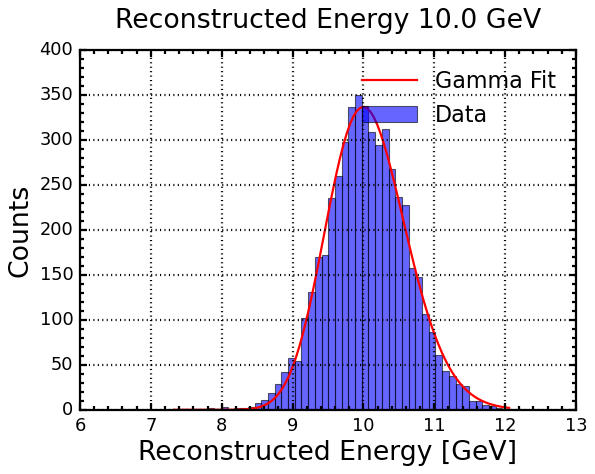

In [72]:
#This cell is left here for debug
print("length of Reco_hist_mlp_all:", len(Reco_hist_mlp_all))
Reco_hist_mlp = Reco_hist_mlp_all[0] # Example for first beta
print("length of Reco_hist_mlp:", len(Reco_hist_mlp))
i_E = 6 # Example index, change as needed
#print(len(Reco_hist_mlp))
#print(Reco_hist_mlp[i_E])
mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all(
    "E_reco",Reco_hist_mlp[i_E]["E_truth"],Reco_hist_mlp[i_E]["counts"],Reco_hist_mlp[i_E]["bin_edges"])

Mean: 0.11282014691988931, Peak: 0.08686111048382694, RMS: 0.045722053347486316
Initial Gamma Fit Parameters: [np.float64(36.63606861763675), np.float64(2.8984553098618653), np.float64(-0.01970318138291988), np.float64(0.045722053347486316)]
Gamma Fit Bounds: lower [np.float64(0.3663606861763675), np.float64(-0.7101544690138135), np.float64(-1.001970318138292), np.float64(0.004572205334748632)], 
 upper [np.float64(219.8164117058205), np.float64(28.984553098618655), np.float64(9.97044522792562), np.float64(0.45722053347486313)]
Gamma Fit Parameters: [ 3.63853454e+01  1.47615434e+01 -5.71495733e-02  1.14681214e-02]
Gamma Fit Peak: 0.10066947631266347 ± 0.0016903459129593412, Mean: 0.11213759767483882 ± 0.0017392096978144618, Resolution: 0.43768368109567407 ± 0.01690545240484116


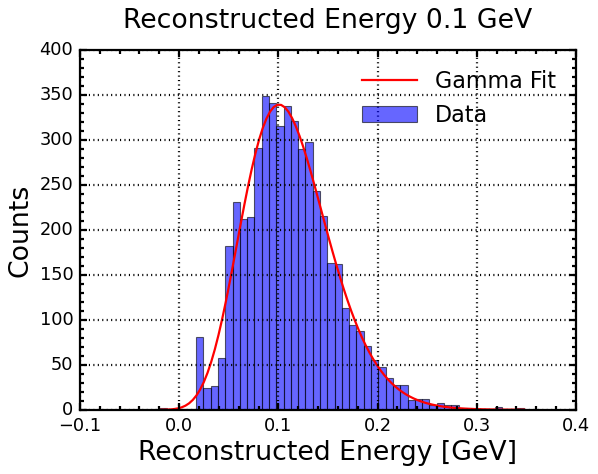

appending results for E = 0.1
Mean_Gamma: 0.11213759767483882 Mean_Gamma_Error: 0.0017392096978144618
Peak_Gamma: 0.10066947631266347 Peak_Gamma_Error: 0.0016903459129593412
Mean: 0.26920184225619076, Peak: 0.25014056789892253, RMS: 0.07468246119730161
Initial Gamma Fit Parameters: [np.float64(61.61296987086828), np.float64(3.3095605290425434), np.float64(0.02203571646585003), np.float64(0.07468246119730161)]
Gamma Fit Bounds: lower [np.float64(0.6161296987086827), np.float64(-0.6690439470957457), np.float64(-0.997796428353415), np.float64(0.007468246119730161)], 
 upper [np.float64(369.67781922520965), np.float64(33.09560529042543), np.float64(10.033053574698775), np.float64(0.7468246119730161)]
Gamma Fit Parameters: [6.14397014e+01 7.08170983e+00 7.18712567e-02 2.80013544e-02]
Gamma Fit Peak: 0.24216736913492512 ± 0.0008643499597657635, Mean: 0.2701687235732588 ± 0.0009203357825080904, Resolution: 0.3077035302923592 ± 0.003811411126620374


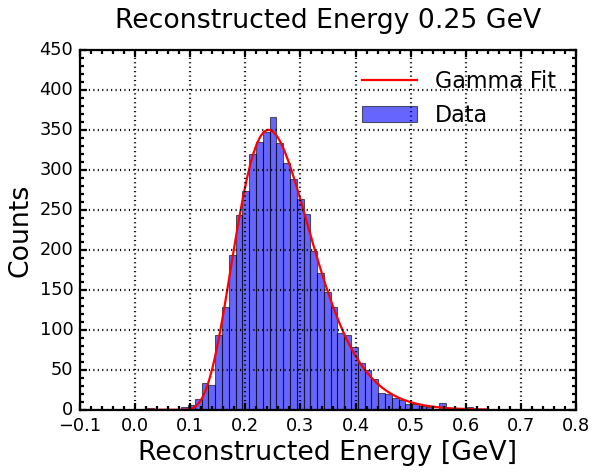

appending results for E = 0.25
Mean_Gamma: 0.2701687235732588 Mean_Gamma_Error: 0.0009203357825080904
Peak_Gamma: 0.24216736913492512 Peak_Gamma_Error: 0.0008643499597657635
Mean: 0.538842869995382, Peak: 0.4938438826615428, RMS: 0.11609593475247272
Initial Gamma Fit Parameters: [np.float64(100.60160480154154), np.float64(4.461147717452284), np.float64(0.020921755668899072), np.float64(0.11609593475247272)]
Gamma Fit Bounds: lower [np.float64(1.0060160480154154), np.float64(-0.5538852282547716), np.float64(-0.9979078244331101), np.float64(0.011609593475247273)], 
 upper [np.float64(603.6096288092492), np.float64(44.61147717452284), np.float64(10.031382633503348), np.float64(1.1609593475247273)]
Gamma Fit Parameters: [ 9.98172914e+01  2.48411445e+01 -2.35115906e-02  2.26011074e-02]
Gamma Fit Peak: 0.5153246785274824 ± 0.001878272873980524, Mean: 0.5379257859686394 ± 0.0019098127354241375, Resolution: 0.21859215907488957 ± 0.002940148812393396


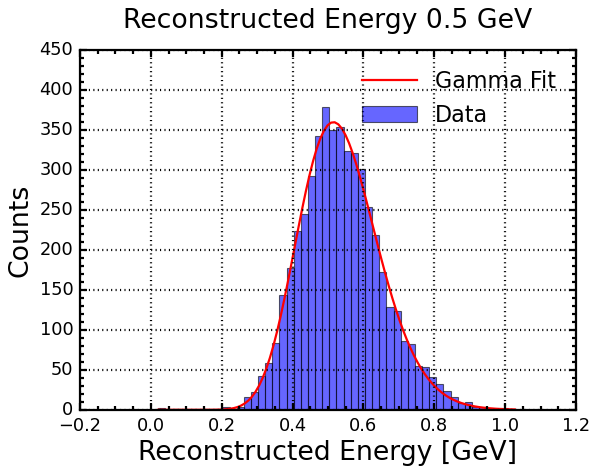

appending results for E = 0.5
Mean_Gamma: 0.5379257859686394 Mean_Gamma_Error: 0.0019098127354241375
Peak_Gamma: 0.5153246785274824 Peak_Gamma_Error: 0.001878272873980524
Mean: 1.0647215037126732, Peak: 1.0086818487156082, RMS: 0.16151230436828265
Initial Gamma Fit Parameters: [np.float64(140.9873578470991), np.float64(4.100525321151009), np.float64(0.4024362099730813), np.float64(0.16151230436828265)]
Gamma Fit Bounds: lower [np.float64(1.409873578470991), np.float64(-0.589947467884899), np.float64(-0.9597563790026918), np.float64(0.016151230436828267)], 
 upper [np.float64(845.9241470825946), np.float64(41.005253211510095), np.float64(10.603654314959622), np.float64(1.6151230436828266)]
Gamma Fit Parameters: [1.40436931e+02 4.10052532e+01 4.68102761e-02 2.49024325e-02]
Gamma Fit Peak: 1.0430383956480123 ± 0.0030886488126872285, Mean: 1.067940828193797 ± 0.0031196763611753327, Resolution: 0.15288371443727705 ± 0.002177360136525486


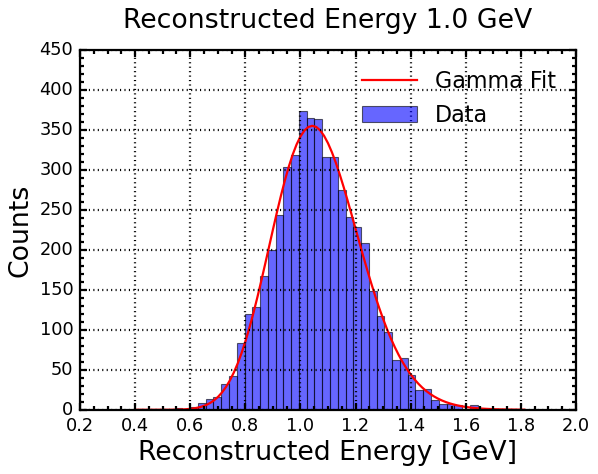

appending results for E = 1.0
Mean_Gamma: 1.067940828193797 Mean_Gamma_Error: 0.0031196763611753327
Peak_Gamma: 1.0430383956480123 Peak_Gamma_Error: 0.0030886488126872285
Mean: 2.0468323734798646, Peak: 2.0347284107037824, RMS: 0.23624539323135826
Initial Gamma Fit Parameters: [np.float64(188.10823499891825), np.float64(3.1571952487364388), np.float64(1.3009595404339487), np.float64(0.23624539323135826)]
Gamma Fit Bounds: lower [np.float64(1.8810823499891824), np.float64(-0.684280475126356), np.float64(-0.8699040459566051), np.float64(0.023624539323135827)], 
 upper [np.float64(1128.6494099935094), np.float64(31.57195248736439), np.float64(11.951439310650922), np.float64(2.3624539323135827)]
Gamma Fit Parameters: [1.87796335e+02 3.15719525e+01 7.29357524e-01 4.18686056e-02]
Gamma Fit Peak: 2.00936254562014 ± 0.005252356008830068, Mean: 2.0512311512287322 ± 0.005321049413241194, Resolution: 0.1170795150512146 ± 0.0019313261722175633


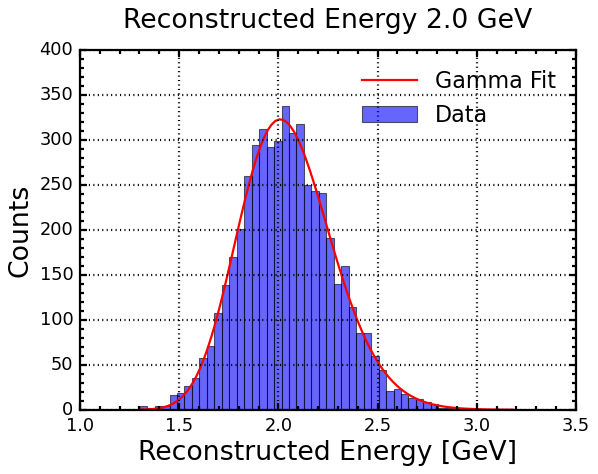

appending results for E = 2.0
Mean_Gamma: 2.0512311512287322 Mean_Gamma_Error: 0.005321049413241194
Peak_Gamma: 2.00936254562014 Peak_Gamma_Error: 0.005252356008830068
Mean: 5.017109293526676, Peak: 4.965931658801972, RMS: 0.39589856412837077
Initial Gamma Fit Parameters: [np.float64(322.5546388267271), np.float64(3.3073935794099967), np.float64(3.707716924430866), np.float64(0.39589856412837077)]
Gamma Fit Bounds: lower [np.float64(3.2255463882672712), np.float64(-0.6692606420590004), np.float64(-0.6292283075569134), np.float64(0.03958985641283708)], 
 upper [np.float64(1935.3278329603627), np.float64(33.07393579409997), np.float64(15.5615753866463), np.float64(3.9589856412837077)]
Gamma Fit Parameters: [3.25417073e+02 3.30739358e+01 2.67971934e+00 7.10692862e-02]
Gamma Fit Peak: 4.959191058086198 ± 0.00776460642357022, Mean: 5.030260344280407 ± 0.00786136424926773, Resolution: 0.08241647825564502 ± 0.0011310887820020492


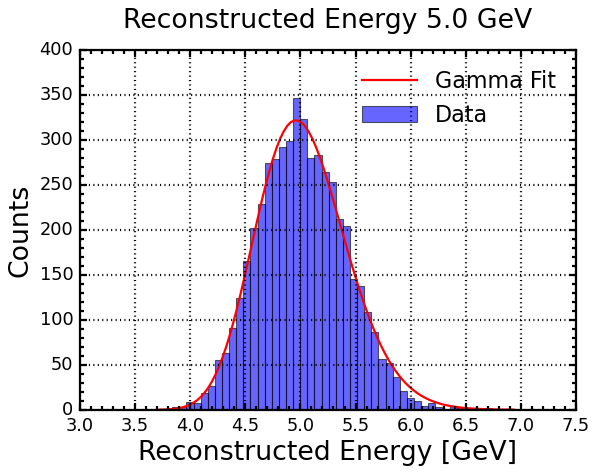

appending results for E = 5.0
Mean_Gamma: 5.030260344280407 Mean_Gamma_Error: 0.00786136424926773
Peak_Gamma: 4.959191058086198 Peak_Gamma_Error: 0.00776460642357022
Mean: 10.048824104130446, Peak: 9.92927033338182, RMS: 0.5707707736170307
Initial Gamma Fit Parameters: [np.float64(472.7292485066336), np.float64(4.7656342431345395), np.float64(7.328739360400733), np.float64(0.5707707736170307)]
Gamma Fit Bounds: lower [np.float64(4.727292485066336), np.float64(-0.523436575686546), np.float64(-0.26712606395992666), np.float64(0.05707707736170307)], 
 upper [np.float64(2836.3754910398015), np.float64(47.656342431345394), np.float64(20.993109040601098), np.float64(5.707707736170306)]
Gamma Fit Parameters: [4.70636147e+02 4.76563424e+01 6.19475377e+00 8.15245773e-02]
Gamma Fit Peak: 9.99839235993131 ± 0.011905143698437013, Mean: 10.079916937213088 ± 0.012015517229876704, Resolution: 0.05628837796383891 ± 0.0008246189314514224


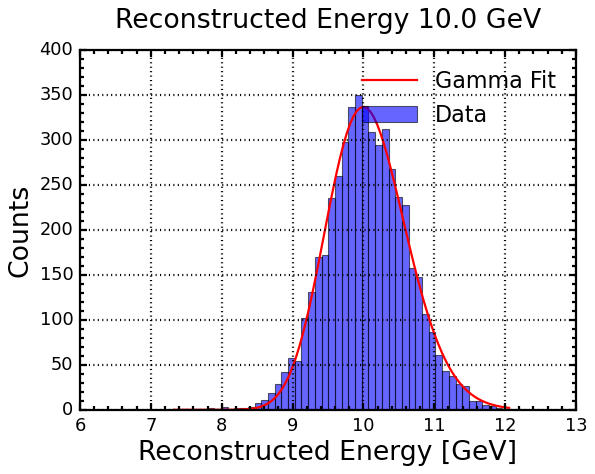

appending results for E = 10.0
Mean_Gamma: 10.079916937213088 Mean_Gamma_Error: 0.012015517229876704
Peak_Gamma: 9.99839235993131 Peak_Gamma_Error: 0.011905143698437013
Mean: 20.023769529743156, Peak: 20.11009330862016, RMS: 0.832843273565544
Initial Gamma Fit Parameters: [np.float64(684.4481899461291), np.float64(3.433010646209265), np.float64(17.164609704968868), np.float64(0.832843273565544)]
Gamma Fit Bounds: lower [np.float64(6.844481899461291), np.float64(-0.6566989353790735), np.float64(0.716460970496887), np.float64(0.0832843273565544)], 
 upper [np.float64(4106.689139676775), np.float64(34.33010646209265), np.float64(35.7469145574533), np.float64(8.32843273565544)]
Gamma Fit Parameters: [6.83958722e+02 3.43301065e+01 1.51792727e+01 1.42545405e-01]
Gamma Fit Peak: 19.930326205139583 ± 0.014927257795072433, Mean: 20.07287160984253 ± 0.015106180317729825, Resolution: 0.04190601744765868 ± 0.0005292669675218715


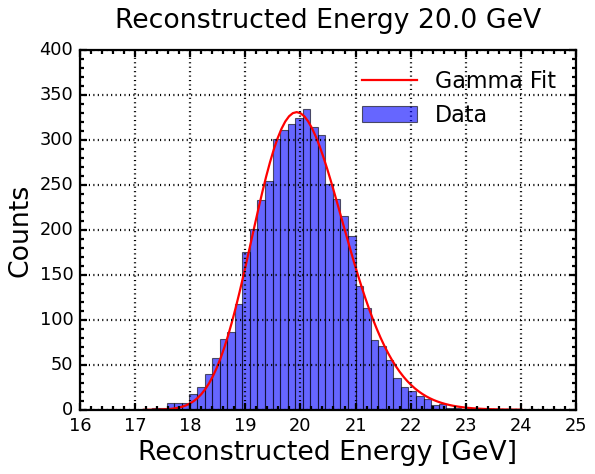

appending results for E = 20.0
Mean_Gamma: 20.07287160984253 Mean_Gamma_Error: 0.015106180317729825
Peak_Gamma: 19.930326205139583 Peak_Gamma_Error: 0.014927257795072433
Mean: 30.025172149487844, Peak: 30.172084568995473, RMS: 1.0348211260600586
Initial Gamma Fit Parameters: [np.float64(895.6854766754275), np.float64(4.96884223143029), np.float64(24.883309236344378), np.float64(1.0348211260600586)]
Gamma Fit Bounds: lower [np.float64(8.956854766754274), np.float64(-0.503115776856971), np.float64(1.4883309236344378), np.float64(0.10348211260600587)], 
 upper [np.float64(5374.112860052564), np.float64(49.6884223143029), np.float64(47.32496385451657), np.float64(10.348211260600586)]
Gamma Fit Parameters: [8.96564245e+02 4.96884223e+01 2.27538510e+01 1.47587503e-01]
Gamma Fit Peak: 29.939653666200996 ± 0.030348214267831315, Mean: 30.087241169672602 ± 0.030610834583121214, Resolution: 0.034748048414416186 ± 0.0006938869105438809


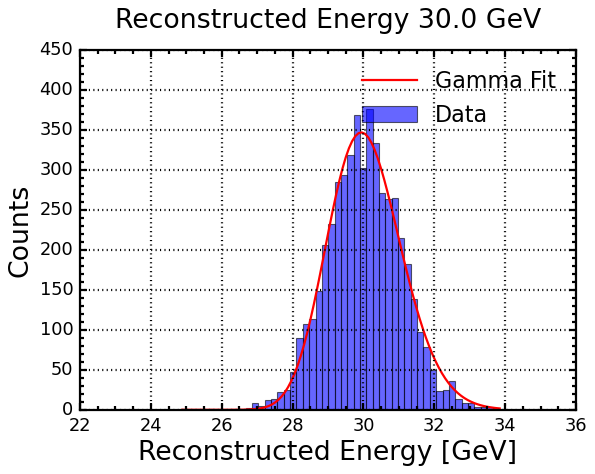

appending results for E = 30.0
Mean_Gamma: 30.087241169672602 Mean_Gamma_Error: 0.030610834583121214
Peak_Gamma: 29.939653666200996 Peak_Gamma_Error: 0.030348214267831315
Mean: 40.03768361038444, Peak: 39.84212082538501, RMS: 1.199948407079292
Initial Gamma Fit Parameters: [np.float64(1078.2527595737524), np.float64(4.749416407152999), np.float64(34.338628958064945), np.float64(1.199948407079292)]
Gamma Fit Bounds: lower [np.float64(10.782527595737525), np.float64(-0.5250583592847), np.float64(2.4338628958064947), np.float64(0.1199948407079292)], 
 upper [np.float64(6469.516557442515), np.float64(47.494164071529994), np.float64(61.50794343709742), np.float64(11.99948407079292)]
Gamma Fit Parameters: [1.07834965e+03 4.74941641e+01 3.18477371e+01 1.73838208e-01]
Gamma Fit Peak: 39.93019921476614 ± 0.02108958394305952, Mean: 40.104037422401426 ± 0.02127164074421722, Resolution: 0.030002944781390217 ± 0.00036197233647681403


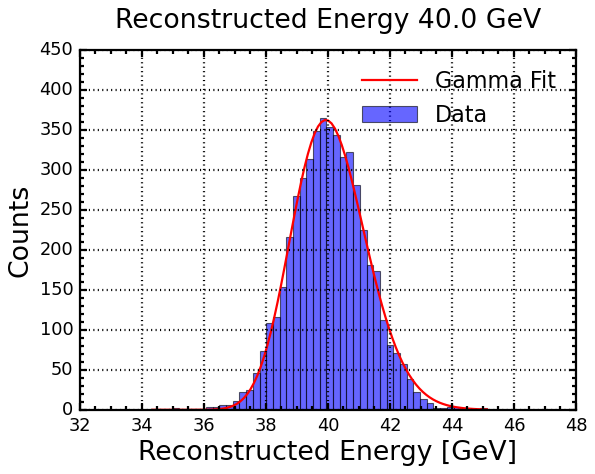

appending results for E = 40.0
Mean_Gamma: 40.104037422401426 Mean_Gamma_Error: 0.02127164074421722
Peak_Gamma: 39.93019921476614 Peak_Gamma_Error: 0.02108958394305952
Mean: 50.128524528452, Peak: 50.41040744069605, RMS: 1.3218626336866106
Initial Gamma Fit Parameters: [np.float64(1117.6034045473098), np.float64(4.9451897934106235), np.float64(43.591662924054084), np.float64(1.3218626336866106)]
Gamma Fit Bounds: lower [np.float64(11.176034045473099), np.float64(-0.5054810206589376), np.float64(3.3591662924054084), np.float64(0.13218626336866107)], 
 upper [np.float64(6705.620427283859), np.float64(49.451897934106235), np.float64(75.38749438608113), np.float64(13.218626336866105)]
Gamma Fit Parameters: [1.11588378e+03 4.94518979e+01 4.09004990e+01 1.88246541e-01]
Gamma Fit Peak: 50.02140116131359 ± 0.033866086716562195, Mean: 50.20964770208074 ± 0.03417580139581767, Resolution: 0.026464435440959683 ± 0.00046227220800793337


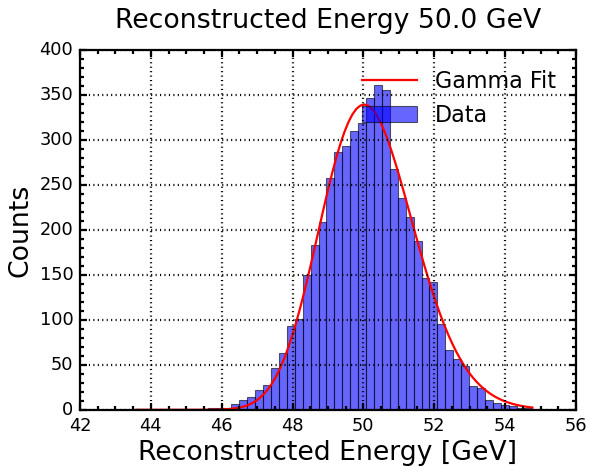

appending results for E = 50.0
Mean_Gamma: 50.20964770208074 Mean_Gamma_Error: 0.03417580139581767
Peak_Gamma: 50.02140116131359 Peak_Gamma_Error: 0.033866086716562195
Mean: 59.91737273249004, Peak: 59.95679055303687, RMS: 1.421004258758376
Initial Gamma Fit Parameters: [np.float64(1257.5444635134659), np.float64(4.487407635369057), np.float64(53.540747371845754), np.float64(1.421004258758376)]
Gamma Fit Bounds: lower [np.float64(12.575444635134659), np.float64(-0.5512592364630943), np.float64(4.354074737184575), np.float64(0.1421004258758376)], 
 upper [np.float64(7545.266781080795), np.float64(44.87407635369057), np.float64(90.31112105776863), np.float64(14.21004258758376)]
Gamma Fit Parameters: [1.25265927e+03 4.48740763e+01 5.05524346e+01 2.10840179e-01]
Gamma Fit Peak: 59.80285272259242 ± 0.030540226244869777, Mean: 60.01369290156734 ± 0.030818689318303845, Resolution: 0.02361724507180793 ± 0.0003505616796459933


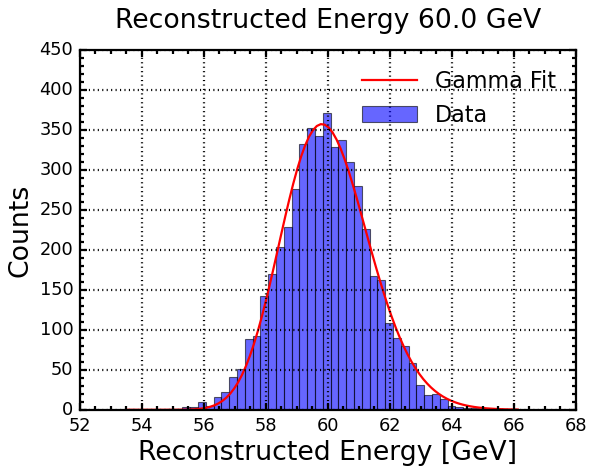

appending results for E = 60.0
Mean_Gamma: 60.01369290156734 Mean_Gamma_Error: 0.030818689318303845
Peak_Gamma: 59.80285272259242 Peak_Gamma_Error: 0.030540226244869777


In [73]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
def OutputCSV(Reco_hist, Energy_test, CSV_name):
    results = []
    for i_E in range(len(Energy_test)):
        mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
        mean_log_normal,mean_log_normal_error,peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
        mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])
        print("appending results for E =", Energy_test[i_E])
        print("Mean_Gamma:", mean_gamma, "Mean_Gamma_Error:", mean_gamma_error)
        print("Peak_Gamma:", peak_gamma, "Peak_Gamma_Error:", peak_gamma_error)
        results.append({
            "ParticleEnergy": Energy_test[i_E],
            "Mean_Gauss": mean_gauss,
            "Mean_Gauss_Error": mean_gauss_error,
            "Peak_Gauss": peak_gauss,
            "Peak_Gauss_Error": peak_gauss_error,
            "Res_Gauss": res_gauss,
            "Res_Gauss_Error": res_gauss_error,
            "Mean_Gamma": mean_gamma,
            "Mean_Gamma_Error": mean_gamma_error,
            "Peak_Gamma": peak_gamma,
            "Peak_Gamma_Error": peak_gamma_error,
            "Res_Gamma": res_gamma,
            "Res_Gamma_Error": res_gamma_error,
            "Mean_LogNormal": mean_log_normal,
            "Mean_LogNormal_Error": mean_log_normal_error,
            "Peak_LogNormal": peak_log_normal,
            "Peak_LogNormal_Error": peak_log_normal_error,
            "Res_LogNormal": res_log_normal,
            "Res_LogNormal_Error": res_log_normal_error
        })
    df = pd.DataFrame(results)
    df.to_csv(CSV_name, index=False)
outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP0_Fit.csv")
OutputCSV(Reco_hist_mlp_all[0], Energy_test, outputfile_name)
# for i_para, para in enumerate(ParameterScan):
#     if i_para != 0:
#         continue  # 
#     #outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_LR{para:.0e}_Fit.csv")
#     outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Fit.csv")
#     OutputCSV(Reco_hist_mlp_all[i_para], Energy_test, outputfile_name)
#     print(f"Saved fit results to {outputfile_name}")

In [74]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
def get_max_depth(tree):
    if "left_child" not in tree and "right_child" not in tree:
        return 1
    left_depth = get_max_depth(tree["left_child"]) if "left_child" in tree else 0
    right_depth = get_max_depth(tree["right_child"]) if "right_child" in tree else 0
    return 1 + max(left_depth, right_depth)


def summarize_lgbm_model(lgb_reg):
    booster = lgb_reg.booster_
    model_info = booster.dump_model()
    print("===== LightGBM Model Summary =====")
    print("Initial Model Parameters:")
    for k, v in lgb_reg.get_params().items():
        print(f"  {k}: {v}")
    print("Final Model Parameters:")

    trees = model_info['tree_info']
    num_trees = len(trees)
    max_depth = get_max_depth(trees)
    num_leaves = max(tree['num_leaves'] for tree in trees)
    
    print("\nTrained model statistics:")
    print(f"  Number of trees   : {num_trees}")
    print(f"  Max tree depth    : {max_depth}")
    print(f"  Max number of leaves per tree : {num_leaves}")

def lightgbm_train(X_train, y_train, X_val, y_val):
    lgb_reg = lgb.LGBMRegressor(
        objective='regression_l2',
        n_estimators=1000,           # 设大一些，early stopping 会截断
        learning_rate=0.001,
        max_depth=7,
        num_leaves=32,
        min_child_samples=100,
        random_state=42
    )
    lgb_reg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )
    evals_result = lgb_reg.evals_result_
    plt.figure(figsize=(8, 6))
    plt.plot(evals_result['training']['rmse'], label='Train RMSE')
    plt.plot(evals_result['valid_1']['rmse'], label='Validation RMSE')
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.title("LightGBM Training Curve (RMSE)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    return lgb_reg

X = np.vstack([X_train_scaled, X_validate_scaled])
y_pred = mlp_model(torch.tensor(X, dtype=torch.float32).to(device)).detach().cpu().numpy()
y_pred_calib = y_pred*(1-E_calib_fit(y_pred))
X_train2 = np.hstack([
    E_layers_uniform, 
    E_layers_uniform_ratio,
    N_layers_uniform,
    N_layers_uniform_ratio,
    E_N_layers_uniform, 
    y_pred_calib[:, np.newaxis],
])
X_test2 = np.hstack(
    [E_layers_test, 
        E_layers_test_ratio,
     N_layers_test,
        N_layers_test_ratio,
     E_N_layers_test, 
     y_pred_test_mlp_calib[:,np.newaxis],
])
y_train2 = y_pred_calib/E_truth_uniform
y_test2 =  y_pred_test_mlp_calib/E_truth_test

#Scaling
random_state = 42
val_split = 0.2
X_train2, X_validate2, y_train2, y_validate2 = train_test_split(X_train2, y_train2, test_size=val_split, random_state=random_state)
scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_train2)
X_validate_scaled2 = scaler.transform(X_validate2)

lgb_reg = lightgbm_train(X_train_scaled2, y_train2, X_validate_scaled2, y_validate2)
y_pred_val_gbm = lgb_reg.predict(X_validate_scaled2)
y_pred_test_gbm = lgb_reg.predict(scaler.transform(X_test2))
summarize_lgbm_model(lgb_reg)
del lgb_reg
gc.collect()

y_pred_test_gbm_calib = y_pred_test_mlp_calib / y_pred_test_gbm
Reco_hist_mlp2 = build_reco_hist(y_pred_test_gbm_calib, E_truth_test, Energy_test, Nbins=50)
Reco_hist_mlp_all.append(Reco_hist_mlp2)
outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP1_Fit.csv")
OutputCSV(Reco_hist_mlp_all[1], Energy_test, outputfile_name)

ModuleNotFoundError: No module named 'lightgbm'